In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import statsmodels.api as sm

import os

C:\Program Files\Anaconda3\envs\carmi_thesis_3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import importlib
import plot, loaders
plot = importlib.reload(plot)
loaders = importlib.reload(loaders)

In [3]:
PGS_DIR = os.path.join("data", "pgs")
SAVE_FIG_DIR = "figure5"

# Parallel Coordinates of Parents-to-Gain

## Longevity Height Model

In [4]:
longevity_data = loaders.load_longevity_data(pgs_col=os.path.join(PGS_DIR, "longevity_height"))
longevity_data.head(3)

const  Gender  Age       PGS  Height
FID IID                                      
2   427    1.0       0   61  0.000022  1.5748
    448    1.0       1   62  0.000027  1.7780
11  615    1.0       0   64  0.000042  1.5748

In [5]:
height_model_covar = sm.OLS(endog=longevity_data["Height"], exog=longevity_data[["const", "Gender", "Age"]]).fit()
print(height_model_covar.rsquared)
height_model_pgs_res = sm.OLS(endog=height_model_covar.resid, exog=longevity_data[["const", "PGS"]]).fit()
print(height_model_pgs_res.rsquared)

0.608383543561912
0.24813922444162362


### Prediction

In [6]:
longevity_so_10_height_pgs = pd.concat({"random": loaders.load_pgs(os.path.join(PGS_DIR, "longevity_so_random_10_height")),
                                        "actual": loaders.load_pgs(os.path.join(PGS_DIR, "longevity_so_actual_10_height"))},
                                       axis="index", names=["matching"])
longevity_so_10_height_pred = height_model_pgs_res.predict(sm.add_constant(longevity_so_10_height_pgs))
longevity_so_10_height_pred.sample(4)

matching  FID        IID 
random    3004_5052  SO00    0.018788
actual    6716_6717  SO09   -0.049362
random    4475_3385  SO04   -0.003058
          3033_4137  SO00    0.028670
dtype: float64

## Analyze

### Calculate Gain

In [7]:
gain = longevity_so_10_height_pred.groupby(["matching", "FID"]).agg(["max", "mean"])
gain = gain["max"] - gain["mean"]
gain = gain.rename("gain")
gain.sample(n=6)

matching  FID      
actual    3527_3528    0.022735
random    4476_3244    0.035682
          5227_6222    0.018151
          2613_3197    0.037978
          2798_7069    0.052592
          7191_4233    0.019301
Name: gain, dtype: float64

### Get parents' values

In [8]:
def extract_parents_values(source, target_to_extract_from):
    # Simulations' FID contain parents IDs:
    source_ids = source.index.to_frame().reset_index(drop=True)
    # Split the FID into its parents IID components:
    parents_ids = source_ids["FID"].str.split("_", expand=True).astype(int)
    # Convert the new parents IID component into their corresponding PG score:
    parents_vals = parents_ids.applymap(lambda x: target_to_extract_from.xs(x, level="IID").iloc[0])
    # Concat into multi column index (measurement, parents_num) - i.e. ({id,val}, {0,1})
    parents = pd.concat({"id": parents_ids, "val": parents_vals}, axis="columns")
    # Set the original index to be compatible to how source looks like:
    parents = parents.set_index(source_ids.set_index(["matching", "FID"]).index)
    # simple rearrange of the columns to ({0, 1}, {id, val})
    parents = parents.swaplevel(axis="columns").sort_index(axis="columns")
    # names the parent level ({0,1} values) and stack it as part of index:
    parents.columns.names = ["parent", None]
    parents = parents.stack(level="parent")
    return parents

In [9]:
# longevity_parents_vals = extract_parents_values(gain, height_model_pgs_res.fittedvalues)
longevity_parents_vals = extract_parents_values(gain, longevity_data["Height"])
longevity_parents_vals.head()

id     val
matching FID       parent              
actual   1130_1131 0       1130  1.5875
                   1       1131  1.6764
         1235_1236 0       1235  1.7272
                   1       1236  1.5748
         1261_1262 0       1261  1.5240

### Plot Parallel Coordinates

In [10]:
data = longevity_parents_vals.reset_index("parent").join(gain.to_frame())
data.head(4)

parent    id     val      gain
matching FID                                      
actual   1130_1131       0  1130  1.5875  0.021447
         1130_1131       1  1131  1.6764  0.021447
         1235_1236       0  1235  1.7272  0.025095
         1235_1236       1  1236  1.5748  0.025095

In [11]:
# pd.plotting.parallel_coordinates(frame=data.xs("actual"), class_column="parent", cols=["val", "gain"])

In [12]:
import plotly.offline as pyo
import plotly.plotly as py
import plotly.graph_objs as go
pyo.init_notebook_mode(connected=True)

In [14]:
plot_data = data.xs("actual")
plot_data = [go.Parcoords(line=dict(color=plot_data["val"],
                                    colorscale='Portland',
                                    showscale=True),
                          dimensions=[dict(label="Parents Height",
                                           values=plot_data["val"],
                                           tickformat="3f"),
                                      dict(label="Gain",
                                           values=plot_data["gain"],
                                           tickformat="3f")])]
fig = go.Figure(data=plot_data)
pyo.iplot(fig, filename='parcoords-basic')

Text(0,0.5,'Parent 1 Height')

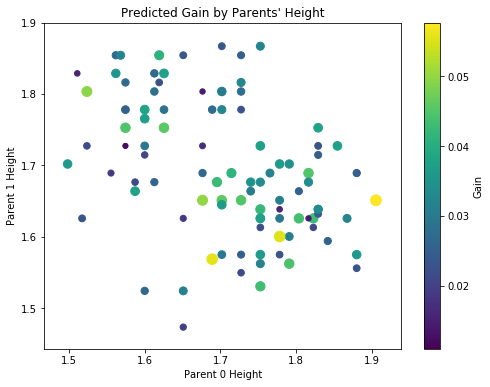

In [15]:
plot_data = data.xs("actual")
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

path_collection = ax.scatter(x=plot_data.loc[plot_data["parent"] == 0, "val"],
                             y=plot_data.loc[plot_data["parent"] == 1, "val"],
                             c=plot_data.loc[plot_data["parent"] == 1, "gain"],
                             s=plot_data.loc[plot_data["parent"] == 1, "gain"] * 2000)
cbar = fig.colorbar(path_collection)
cbar.ax.set_ylabel("Gain")
ax.set_title("Predicted Gain by Parents' Height")
ax.set_xlabel("Parent 0 Height")
ax.set_ylabel("Parent 1 Height")

In [16]:
plot.save_fig(fig, "longevity_actual_scatter_true-height_true-height_gain", SAVE_FIG_DIR)